<a href="https://colab.research.google.com/github/emerson-matos/tcc-notebooks/blob/main/reviews/analise_exploratoria_2018%2Bfiltrado%2Btimechart_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurando ambiente

monta o google drive e define paleta de cores para o seaborn utilizar

In [50]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter

In [51]:
from google.colab import drive
sns.color_palette("tab10")
# drive.mount('/content/gdrive')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

faz o download de stopwords e punkt do nltk

In [52]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Baixe a lista de stopwords em português
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Dados dos hoteis

definindo a data dos arquivos que serão utilizados

In [53]:
date = "2023/07/07"

## Cria o DataFrame

carregamos então o google sheets onde está definida a lista de hotéis em um dataframe pandas e validamos a existencia do sns

In [56]:
hotels = pd.read_csv(f"/content/gdrive/MyDrive/tcc/data/hotels-2023-09-01.csv")[['name', 'stars', 'overall_rating', 'region', 'state', 'qtd_reviews', 'source']]
sns.__version__

'0.12.2'

### carregando um unico arquivo

In [54]:
filename = 'grand-oca-maragogi-gm-reviews.csv'
dados = pd.read_csv(f"/content/gdrive/MyDrive/tcc/data/{date}/{filename}")
dados['source'] = filename.split('.')[0]
dados.loc[1]['text']

'De tudo do Resort um serviço superou as minhas expectativas: a Yasmin é uma manicure sensacional, fez muitíssimo bem meu pé e minha mão, nota mil'

### carregando todos os arquivos da pasta do google drive

In [57]:
import glob
import os

path_to_lookup = f'/content/gdrive/MyDrive/tcc/data/{date}/'
file_pattern = "*.csv"

# setting the path for joining multiple files
files = os.path.join(path_to_lookup, file_pattern)

# list of merged files returned
files = glob.glob(files)

dados = pd.concat(map(lambda file: pd.read_csv(file).assign(source=file.split("/")[-1].split('-gm-reviews')[0]), files), ignore_index=True)

In [58]:
df = dados[['retrieval_date', 'rating', 'relative_date', 'likes', 'user_is_local_guide', 'text', 'source', 'user_reviews']].copy()

### Tratando dataset

#### preparando colunas

Transformamos a data relativa da realização do review em datetime e criamos novas colunas com partes dessa data e também quantidade de reviews de um usuario em um valor inteiro.

##### definindo transformações

In [59]:
from datetime import datetime, timedelta
import re

def transform_user_reviews(x):
  if isinstance(x, str) and x == 'Um':
    1
  elif isinstance(x, str):
    return int(x.replace('.',''))
  return x

def from_relative_date_to_timestamp(row):
  # String de data relativa
  data_relativa_str = row.relative_date
  timestamp = row.retrieval_date

  # Converte a string em um objeto timedelta
  unidade_tempo = data_relativa_str.split()[1]
  quantidade_tempo = 1 if 'um' in data_relativa_str.split()[0] else int(data_relativa_str.split()[0])

  if 'segundo' in unidade_tempo:
      data_relativa = timedelta(seconds=quantidade_tempo)
  elif 'minuto' in unidade_tempo:
      data_relativa = timedelta(minutes=quantidade_tempo)
  elif 'hora' in unidade_tempo:
      data_relativa = timedelta(hours=quantidade_tempo)
  elif 'dia' in unidade_tempo:
      data_relativa = timedelta(days=quantidade_tempo)
  elif 'semana' in unidade_tempo:
      data_relativa = timedelta(weeks=quantidade_tempo)
  elif re.match(r"m(ê|e)s", unidade_tempo):
      data_relativa = timedelta(days=30*quantidade_tempo)
  elif 'ano' in unidade_tempo:
      data_relativa = timedelta(days=365*quantidade_tempo)
  else:
      return timestamp

  # Timestamp parse
  try:
    dt_timestamp = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S.%f')
  except:
    dt_timestamp = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')

  return (dt_timestamp - data_relativa).date()

##### transformações rápidas

In [60]:
df['user_reviews'] = df['user_reviews'].apply(transform_user_reviews).fillna(0) ## número de reviews do autor do review atual

df['data_avaliacao'] = pd.to_datetime(df.apply(from_relative_date_to_timestamp, axis=1)) ## data da avaliação

# Extract month and year from the 'date' column
df['mes_avaliacao'] = df['data_avaliacao'].dt.month
df['ano_avaliacao'] = df['data_avaliacao'].dt.year

# Create a new column representing the combination of month and year
df['mes_ano_avaliacao'] = df['data_avaliacao'].dt.to_period('M')

<Axes: >

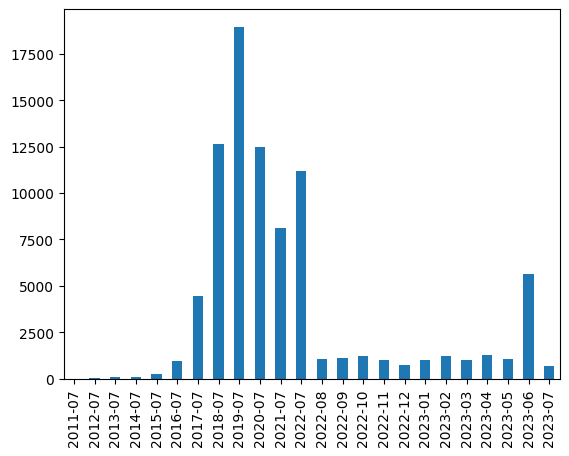

In [61]:
df.mes_ano_avaliacao.value_counts().sort_index().plot.bar()

##### contagem de avaliações por ano sem filtros

In [ ]:
df.ano_avaliacao.value_counts()[df.ano_avaliacao.unique()]

2023    11925
2022    16364
2021     8104
2020    12489
2019    18963
2018    12625
2017     4426
2016      940
2015      247
2014      106
2013       88
2011        5
2012        9
Name: ano_avaliacao, dtype: int64

##### Marcação de avaliações

Marcando avaliações que:

*   Possuem algum caractere
*   Possuem três ou mais caracteres
*   Foram realizados depois de 2017
*   Foram traduzidos pelo google

In [ ]:
df['com_texto'] = df['text'].str.len() > 2
df['nao_vazio'] = df['text'].notna()
df['traduzido'] = df['text'].str.contains('Tradução do Google', na=False)
df['depois_2017'] = df['ano_avaliacao'] > 2017

##### marcando avaliações que serão analisados

Então marcamos as avaliações de interesse, isto é as que iremos utilizar na analise, considerando os seguintes filtros:
*   Reviews que foram públicados após 2017
*   Não foram traduzidos pelo google
*   E possuem mais de 2 caracteres no seu conteudo


É esperado que a avaliação possua algum texto para que possa ser possivel detectar o seu sentimento por esse motivo escolhemos as que possuem mais de 2 caracteres em sua composição. Estamos também interessados em avaliações realizadas no idioma português e por este motivo filtramos também as que foram traduzidas pelo google.

In [ ]:
df['analisar'] = (df['com_texto']) & (~df['traduzido']) & (df['depois_2017'])
analisar_df = df[df['analisar']].copy()

distribuição por ano da quantidade de avaliações que atendem o filtro utilizado

In [ ]:
analisar_df.ano_avaliacao.value_counts()[analisar_df.ano_avaliacao.unique()]

2023     9444
2022    11866
2021     5350
2020     6236
2019     9645
2018     6678
Name: ano_avaliacao, dtype: int64

Tendo a lista de hotéis e a lista de avaliações, mesclamos ambas para poder gerar informações e poder realizar analises temporais de cada hotel e região de forma independente

In [ ]:
import unicodedata

hotels['source_normalized'] = hotels['source'].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore').decode('utf-8'))
df['source_normalized'] = df['source'].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore').decode('utf-8'))

hotels_metadados = pd.merge(hotels, df, on="source_normalized")[['name', 'stars', 'overall_rating', 'region', 'state', 'analisar']]

In [ ]:
hotels_reviews = hotels_metadados.groupby(['name', 'state', 'stars', 'overall_rating', 'analisar']).agg(counts=('analisar', 'size'))
hotels_reviews['total_counts'] = hotels_reviews.groupby('name')['counts'].transform('sum')

hotels_reviews['percentage'] = hotels_reviews['counts'] / hotels_reviews['total_counts'] * 100

#### quantidade de avaliações

##### quantidade total de avaliações

In [ ]:
df.shape[0] ## avaliações no total com e sem texto

86291

##### quantidade de avaliações que serão analisados

In [ ]:
analisar_count = sum(df['analisar'])
analisar_perc = analisar_count / df.shape[0]

##### quantidade de reviews traduzidos ou com menos de 3 caracteres (2 ou menos)

In [ ]:
n_analisar_count = sum(~df['analisar'])
n_analisar_perc = n_analisar_count / df.shape[0]

##### quantidade de reviews traduzidos e sem texto

In [ ]:
traduzido_count = sum(df['traduzido'])
traduzido_perc = traduzido_count / df.shape[0] ## reviews traduzidos

In [ ]:
com_texto_count = sum(df['com_texto'])
com_texto_perc = com_texto_count / df.shape[0] ## reviews traduzidos

In [ ]:
depois_2017_count = sum(df['depois_2017'])
depois_2017_perc = depois_2017_count / df.shape[0] ## reviews traduzidos
antes_2017_count = sum(~df['depois_2017'])
antes_2017_perc = antes_2017_count / df.shape[0] ## reviews traduzidos

In [ ]:
vazio_count = sum(~df['nao_vazio'])
vazio_perc = vazio_count / df.shape[0] ## reviews traduzidos
menos_2_carc_count = df.shape[0] - vazio_count - com_texto_count
menos_2_carc_perc = menos_2_carc_count / df.shape[0] ## reviews traduzidos

valores:

In [ ]:
print(f'''Considerando todas as avaliações obtidas, temos:
\t1. {depois_2017_count}({depois_2017_perc:.2%}) enviadas depois de 2017 e {antes_2017_count}({antes_2017_perc:.2%}) enviadas em 2017 ou antes
\t2. {com_texto_count}({com_texto_perc:.2%}) com texto e 3 ou mais caracteres, {vazio_count}({vazio_perc:.2%}) sem texto e {menos_2_carc_count}({menos_2_carc_perc:.2%}) avaliações com 1 ou 2 caracteres
\t3. {traduzido_count}({traduzido_perc:.2%}) avaliações traduzidas'''
)

Considerando todas as avaliações obtidas, temos:
	1. 80470(93.25%) enviadas depois de 2017 e 5821(6.75%) enviadas em 2017 ou antes
	2. 56893(65.93%) com texto e 3 ou mais caracteres, 29386(34.05%) sem texto e 12(0.01%) avaliações com 1 ou 2 caracteres
	3. 4184(4.85%) avaliações traduzidas


In [ ]:
print(f'E dentre todas as avaliações obtidas utilizaremos para a analise o total de {analisar_count}({analisar_perc:.2%}) e {n_analisar_count}({n_analisar_perc:.2%}) foram ignoradas')

E dentre todas as avaliações obtidas utilizaremos para a analise o total de 49219(57.04%) e 37072(42.96%) foram ignoradas


#### salvando dataset

In [ ]:
from datetime import date
name = str(date.today())
analisar_df.to_csv(f'/content/gdrive/MyDrive/tcc/exploratoria/{name}-analisar.csv', index=False)
df.to_csv(f'/content/gdrive/MyDrive/tcc/exploratoria/{name}-df.csv', index=False)
hotels_reviews.reset_index().to_csv(f'/content/gdrive/MyDrive/tcc/exploratoria/{name}-hotels.csv', index=False)

#### *exemplo*

In [ ]:
df.head()

,retrieval_date,rating,relative_date,likes,user_is_local_guide,text,source,user_reviews,data_avaliacao,mes_avaliacao,ano_avaliacao,mes_ano_avaliacao,com_texto,nao_vazio,traduzido,depois_2017,analisar,source_normalized
0,2023-07-07 00:33:49.026816,5.0,7 horas atrás,-1,True,NaN,hotel-marsol-beach-resort,17,2023-07-06,7,2023,2023-07,False,False,False,True,False,hotel-marsol-beach-resort
1,2023-07-07 00:33:49.066269,5.0,10 horas atrás,-1,False,NaN,hotel-marsol-beach-resort,Um,2023-07-06,7,2023,2023-07,False,False,False,True,False,hotel-marsol-beach-resort
2,2023-07-07 00:33:49.096786,5.0,10 horas atrás,0,False,"Lugar fantástico, recomendo super.",hotel-marsol-beach-resort,9,2023-07-06,7,2023,2023-07,True,True,False,True,True,hotel-marsol-beach-resort
3,2023-07-07 00:33:49.126736,5.0,10 horas atrás,0,False,(Tradução do Google) Ele disse (Original) Exel...,hotel-marsol-beach-resort,2,2023-07-06,7,2023,2023-07,True,True,True,True,False,hotel-marsol-beach-resort
4,2023-07-07 00:33:49.155893,5.0,10 horas atrás,-1,NaN,NaN,hotel-marsol-beach-resort,0,2023-07-06,7,2023,2023-07,False,False,False,True,False,hotel-marsol-beach-resort


In [ ]:
analisar_df.head()

,retrieval_date,rating,relative_date,likes,user_is_local_guide,text,source,user_reviews,data_avaliacao,mes_avaliacao,ano_avaliacao,mes_ano_avaliacao,com_texto,nao_vazio,traduzido,depois_2017,analisar
2,2023-07-07 00:33:49.096786,5.0,10 horas atrás,0,False,"Lugar fantástico, recomendo super.",hotel-marsol-beach-resort,9,2023-07-06,7,2023,2023-07,True,True,False,True,True
5,2023-07-07 00:33:49.185915,5.0,10 horas atrás,0,True,Tudo perfeito,hotel-marsol-beach-resort,36,2023-07-06,7,2023,2023-07,True,True,False,True,True
16,2023-07-07 00:33:50.064473,5.0,11 horas atrás,0,True,excelente!,hotel-marsol-beach-resort,52,2023-07-06,7,2023,2023-07,True,True,False,True,True
17,2023-07-07 00:33:50.080896,5.0,11 horas atrás,0,True,Belo lugar.,hotel-marsol-beach-resort,41,2023-07-06,7,2023,2023-07,True,True,False,True,True
19,2023-07-07 00:33:50.109826,5.0,11 horas atrás,0,False,Ótimo local,hotel-marsol-beach-resort,7,2023-07-06,7,2023,2023-07,True,True,False,True,True


In [ ]:
hotels_reviews

counts  \
name                                  state stars overall_rating analisar           
Cana Brava All Inclusive Resort       BA    4     4.6            False       3028   
                                                                 True        8119   
Grand Oca Maragogi                    AL    5     4.3            False       2427   
                                                                 True        2210   
Hotel Marsol Beach Resort             RN    4     4.2            False       1470   
                                                                 True        1863   
Hotel Vila Galé - Touros              RN    5     4.6            False       1433   
                                                                 True        4369   
Hotel Vila Galé Marés                 BA    5     4.5            False       3550   
                                                                 True        5033   
Iberostar Bahia                       BA    5     4.7            False       7830   
                                                                 True        8383   
La Torre Resort All Inclusive         BA    4     4.7            False       3164   
                                                                 True        3060   
Makai Resort Aracaju - All Inclusive  SE    4     4.3            False       2448   
                                                                 True        2846   
Salinas Maceió All Inclusive Resort   AL    4     4.7            False       2140   
                                                                 True        2541   
Salinas Maragogi All Inclusive Resort AL    5     4.8            False       3539   
                                                                 True        3917   
Transamerica Comandatuba              BA    4     4.8            False       1294   
                                                                 True        1945   

                                                                           total_counts  \
name                                  state stars overall_rating analisar                 
Cana Brava All Inclusive Resort       BA    4     4.6            False            11147   
                                                                 True             11147   
Grand Oca Maragogi                    AL    5     4.3            False             4637   
                                                                 True              4637   
Hotel Marsol Beach Resort             RN    4     4.2            False             3333   
                                                                 True              3333   
Hotel Vila Galé - Touros              RN    5     4.6            False             5802   
                                                                 True              5802   
Hotel Vila Galé Marés                 BA    5     4.5            False             8583   
                                                                 True              8583   
Iberostar Bahia                       BA    5     4.7            False            16213   
                                                                 True             16213   
La Torre Resort All Inclusive         BA    4     4.7            False             6224   
                                                                 True              6224   
Makai Resort Aracaju - All Inclusive  SE    4     4.3            False             5294   
                                                                 True              5294   
Salinas Maceió All Inclusive Resort   AL    4     4.7            False             4681   
                                                                 True              4681   
Salinas Maragogi All Inclusive Resort AL    5     4.8            False             7456   
                                                                 True              7456   
Transamerica Comandatuba        

### analise exploratoria

considerando todas as avaliações, então temos as seguintes metricas:


In [ ]:
df.describe()

,rating,likes,mes_avaliacao,ano_avaliacao
count,86291.000000,86291.000000,86291.000000,86291.000000
mean,4.600630,-0.227880,6.849208,2020.147779
std,0.864428,0.804257,1.333079,1.921575
min,1.000000,-1.000000,1.000000,2011.000000
25%,5.000000,-1.000000,7.000000,2019.000000
50%,5.000000,0.000000,7.000000,2020.000000
75%,5.000000,0.000000,7.000000,2022.000000
max,5.000000,25.000000,12.000000,2023.000000


agora agrupando por hoteis avaliados, considerando avaliações com algum caractere de texto(não vazias), com mais de 2 caracteres, traduzidas pelo google e registradas após 2017.

In [ ]:
df.groupby('source').agg(nao_vazio=('nao_vazio', 'sum'),
                         com_texto=('com_texto', 'sum'),
                         traduzido=('traduzido', 'sum'),
                         depois_2017=('depois_2017', 'sum'))

,nao_vazio,com_texto,traduzido,depois_2017
source,,,,
cana-brava-all-inclusive-resort,8583,8581,141,10656
grand-oca-maragogi,2948,2947,542,4297
hotel-marsol-beach-resort,2150,2150,162,3128
hotel-vila-galé---touros,4481,4480,111,5802
hotel-vila-galé-marés,5723,5721,315,7981
hotel-vila-galé_-eco-resort---cabo,3219,3217,183,4934
iberostar-bahia,10587,10586,1464,14848
la-torre-resort-all-inclusive,3847,3847,496,5722
makai-resort-aracaju---all-inclusive,3180,3180,84,4917


Agora a visualização sepando as avaliações que foram utilizadas na analise e as que não foram considerando informações de estrelas dos hotéis, quantidade de avaliações e classificação da avaliação concedida no momento do registro, temos:

In [ ]:
valores = hotels_metadados.groupby(['state', 'analisar']).agg({'analisar': [ 'count' ],
                                                               'overall_rating': [ 'mean', 'min', 'max' ],
                                                               'stars': [ 'mean' ]})
valores

analisar overall_rating               stars
                  count           mean  min  max      mean
state analisar                                            
AL    False        8106       4.623896  4.3  4.8  4.735998
      True         8668       4.643205  4.3  4.8  4.706853
BA    False       18866       4.653175  4.5  4.8  4.603202
      True        26540       4.638809  4.5  4.8  4.505501
RN    False        2903       4.397451  4.2  4.6  4.493627
      True         6232       4.480424  4.2  4.6  4.701059
SE    False        2448       4.300000  4.3  4.3  4.000000
      True         2846       4.300000  4.3  4.3  4.000000

Similar ao conteúdo acima, porém mais visual

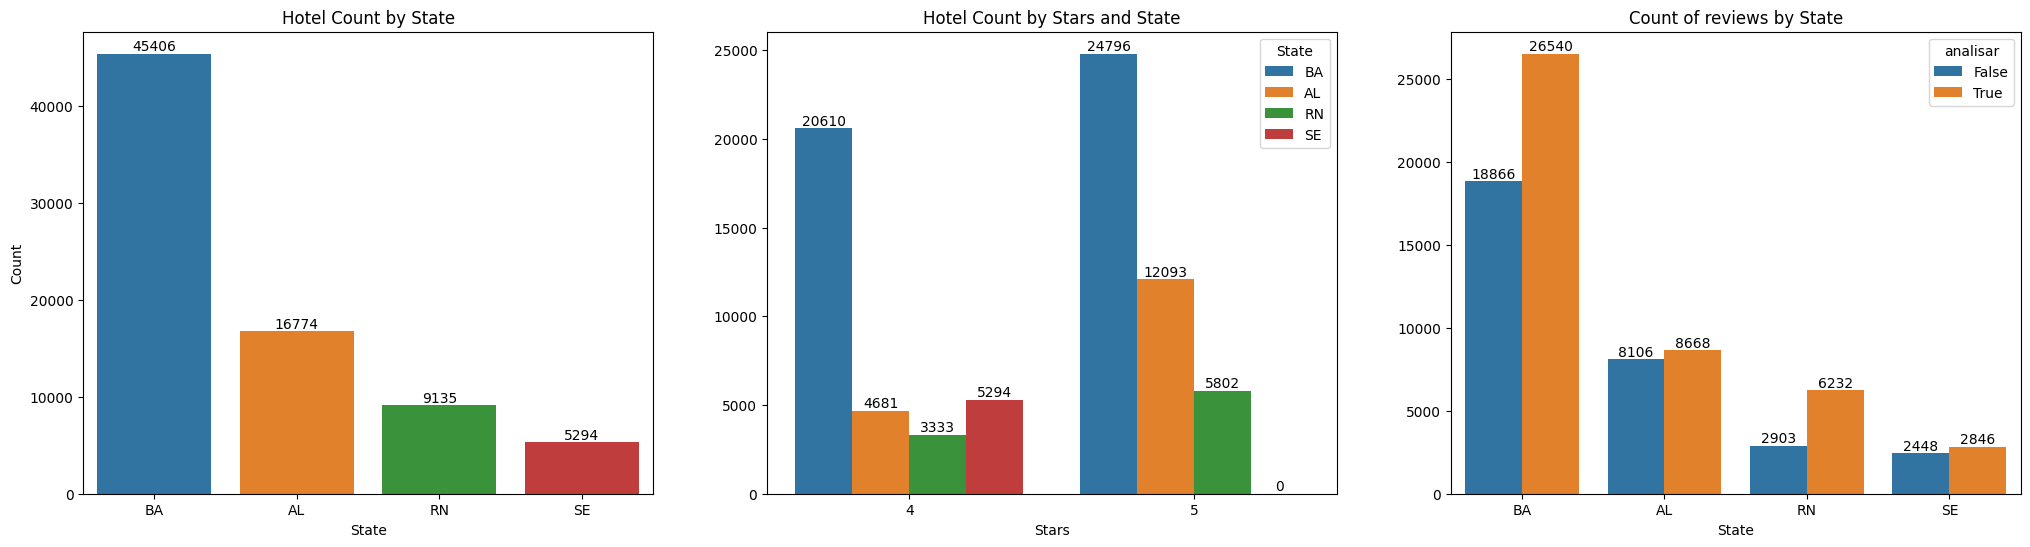

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(25, 6))
state_counts = hotels_reviews.groupby(['state', 'analisar'])['counts'].sum().reset_index().sort_values('counts', ascending=False)

g = sns.barplot(data=state_counts, x='state', hue='analisar', y='counts', ax=axes[2])
axes[2].set_title('Count of reviews by State')
axes[2].set_xlabel('State')
axes[2].set_ylabel('')

sns.countplot(data=hotels_metadados, x='state', ax=axes[0])
axes[0].set_title('Hotel Count by State')
axes[0].set_xlabel('State')
axes[0].set_ylabel('Count')

sns.countplot(data=hotels_metadados, x='stars', hue='state', ax=axes[1])
axes[1].set_title('Hotel Count by Stars and State')
axes[1].set_xlabel('Stars')
axes[1].set_ylabel('')
axes[1].legend(title='State')

for ax in axes.flat:
    # Iterate over each bar in the subplot
    for p in ax.patches:
        # Get the count value of the bar
        count = p.get_height()
        # Add the count value as text annotation
        ax.annotate(f'{int(count)}', (p.get_x() + p.get_width() / 2, p.get_height()),
                          ha='center', va='bottom')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Display the plots
plt.show()

Visualização da distribuição das notas atribuidas individualmente a cada avaliação.
A grande maioria das avaliações 38347 (77,91%) foi realizada e atribuida a maior nota, 5, o que nos leva a acreditar que em grande parte a o sentimento geral é positivo.

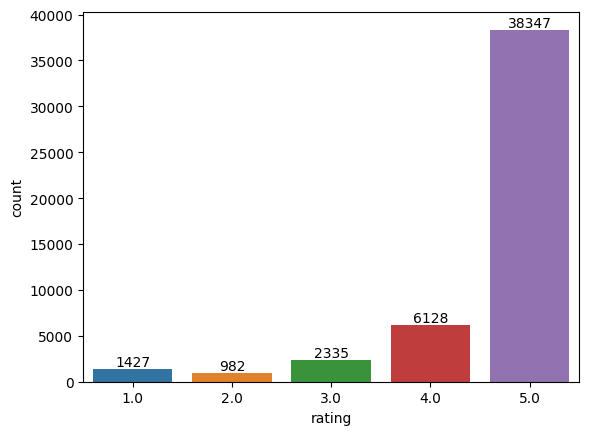

In [ ]:
sns.countplot(x="rating", data=analisar_df)
ax = plt.gca()
# Add count values on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                       ha='center', va='bottom')
plt.show()

Agora estamos considerando apenas avaliações que serão utilizadas na analise, podemos observar a sua evolução em quantidade númerica durante o tempo, podendo notar uma quebra de tendência no crescimento pós 2019, nos anos de 2020 e 2021, provavelmente causado pelo confinamento decorrente da COVID-21 (referências?) e pós flexibilização do confinamento visualizamos um aumento no número de avaliações, levando em consideração que temos apenas 6 meses de avaliação em 2023 então possivelmente seguiremos com a tendencia de aumento de número de avaliações ano após ano.

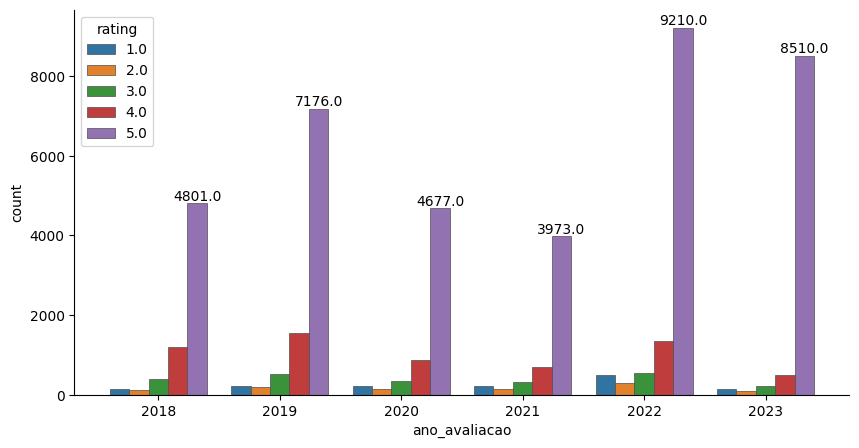

In [ ]:
f, _ = plt.subplots(figsize=(10, 5))

sns.despine(f)

g = sns.countplot(
    x="ano_avaliacao",
    hue="rating",
    data=analisar_df,
    edgecolor=".3",
    linewidth=.5,
)
ax = plt.gca()
# Add count values on top of each bar
for p in ax.patches:
  # Get the count value of the bar
  count = p.get_height()
  if (count > 2000):
    # Add the count value as text annotation
    ax.annotate(count,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 5), textcoords='offset points')

ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.autoscale()
plt.show()

Com o grafico abaixo podemos notar que a variação da nota atribuida tende a diminuir conforme o tempo passa, a quantidade de notas maiores é crescente, mas levando em consideração o grafico acima isso talvez seja causado pela crescete também da quantidade de avaliações com notas entre 4 e 5.

<Figure size 1000x500 with 0 Axes>

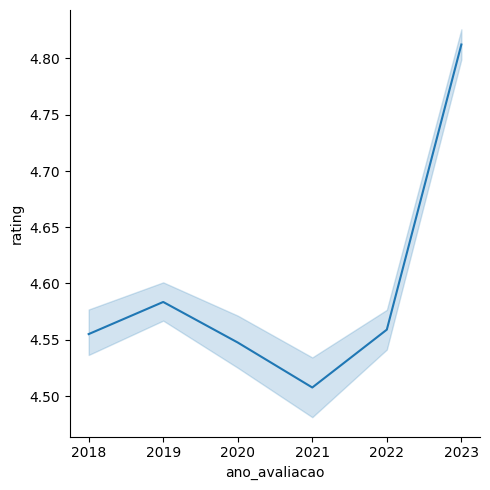

In [ ]:
plt.figure(figsize=(10,5))
sns.relplot(x='ano_avaliacao', y='rating', kind="line", data=analisar_df)

Visualização individual da quantidade de avaliações realiadas anualmente para cada um deles, todos os gráficos possuem linhas referencia posicionadas em 300, 500 e 1000.

<!-- # removidos -->
<!-- # grand-palladium-imbassaí-resort-&-spa 18/19/20/21 -->
<!-- # hotel-coroa-vermelha-beach-all-inclusive 18 / 19 / 20 -->
<!-- # iberostar-selection-praia-do-forte 18 -->
<!-- # sauípe-premium-brisa---all-inclusive 18/19/20 -->

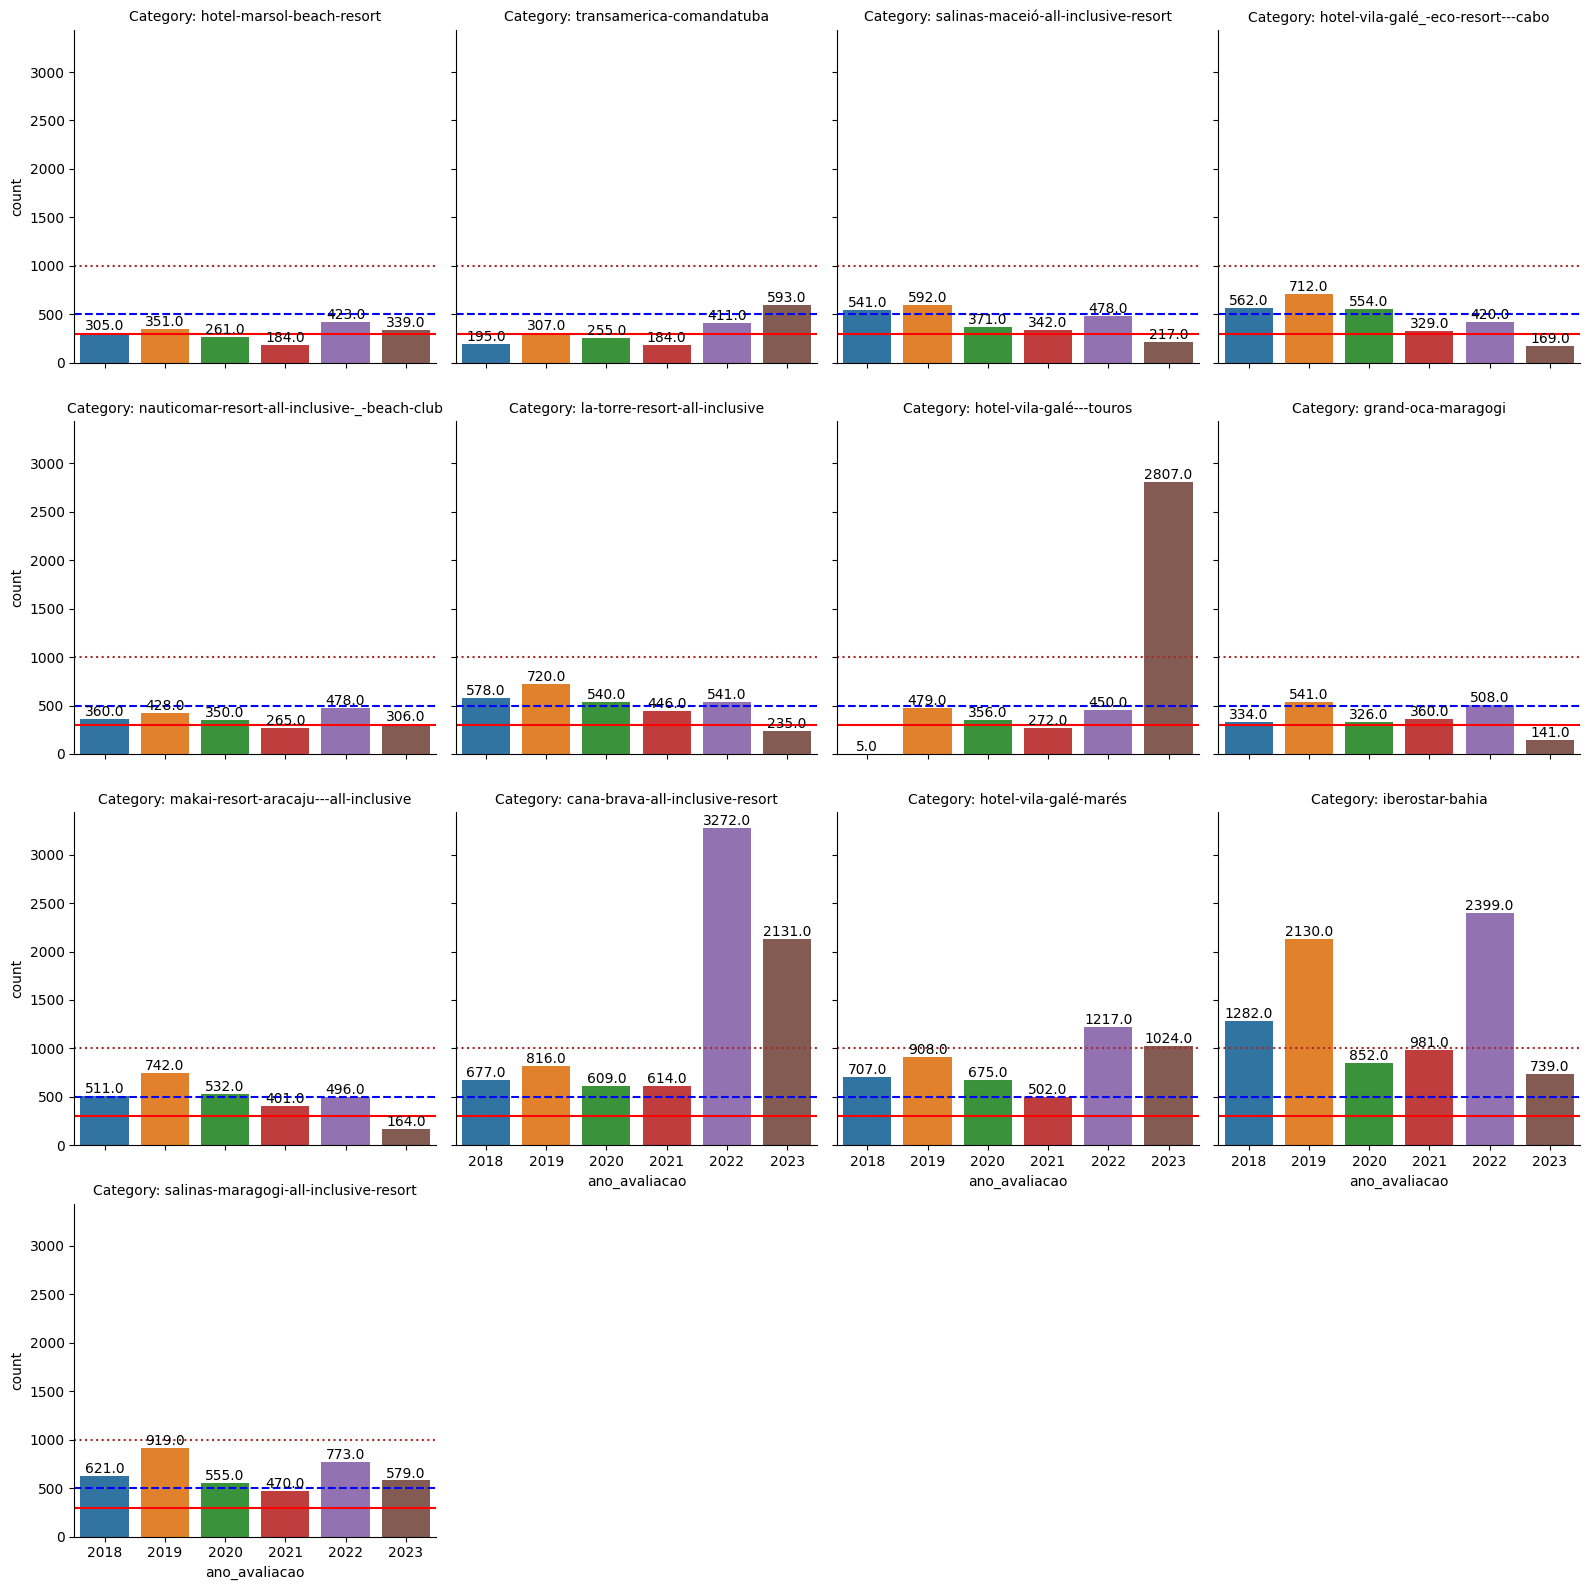

In [ ]:
# Create countplot with subplots
g = sns.catplot(
    x="ano_avaliacao",
    col="source",
    data=analisar_df,
    col_wrap=4,
    kind='count',
    height=4,
    aspect=1,
)

# Iterate over each subplot
for ax in g.axes.flat:
    # Iterate over each bar in the subplot
    for p in ax.patches:
        # Get the count value of the bar
        count = p.get_height()
        # Add the count value as text annotation
        ax.annotate(count,
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center',
                    va='center',
                    xytext=(0, 5), textcoords='offset points')
    ax.axhline(y=300, color='red', linestyle='-')
    ax.axhline(y=500, color='blue', linestyle='--')
    ax.axhline(y=1000, color='brown', linestyle=':')

# Set titles for each subplot
g.set_titles("Category: {col_name}")

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


Visualização da nota individual dos hotéis com base nas avaliaçõesrealizadas durante o tempo.

É fácil notar que a variação esta bastante concentrada na região acima de 4 para quase todos os hoteis analisados.

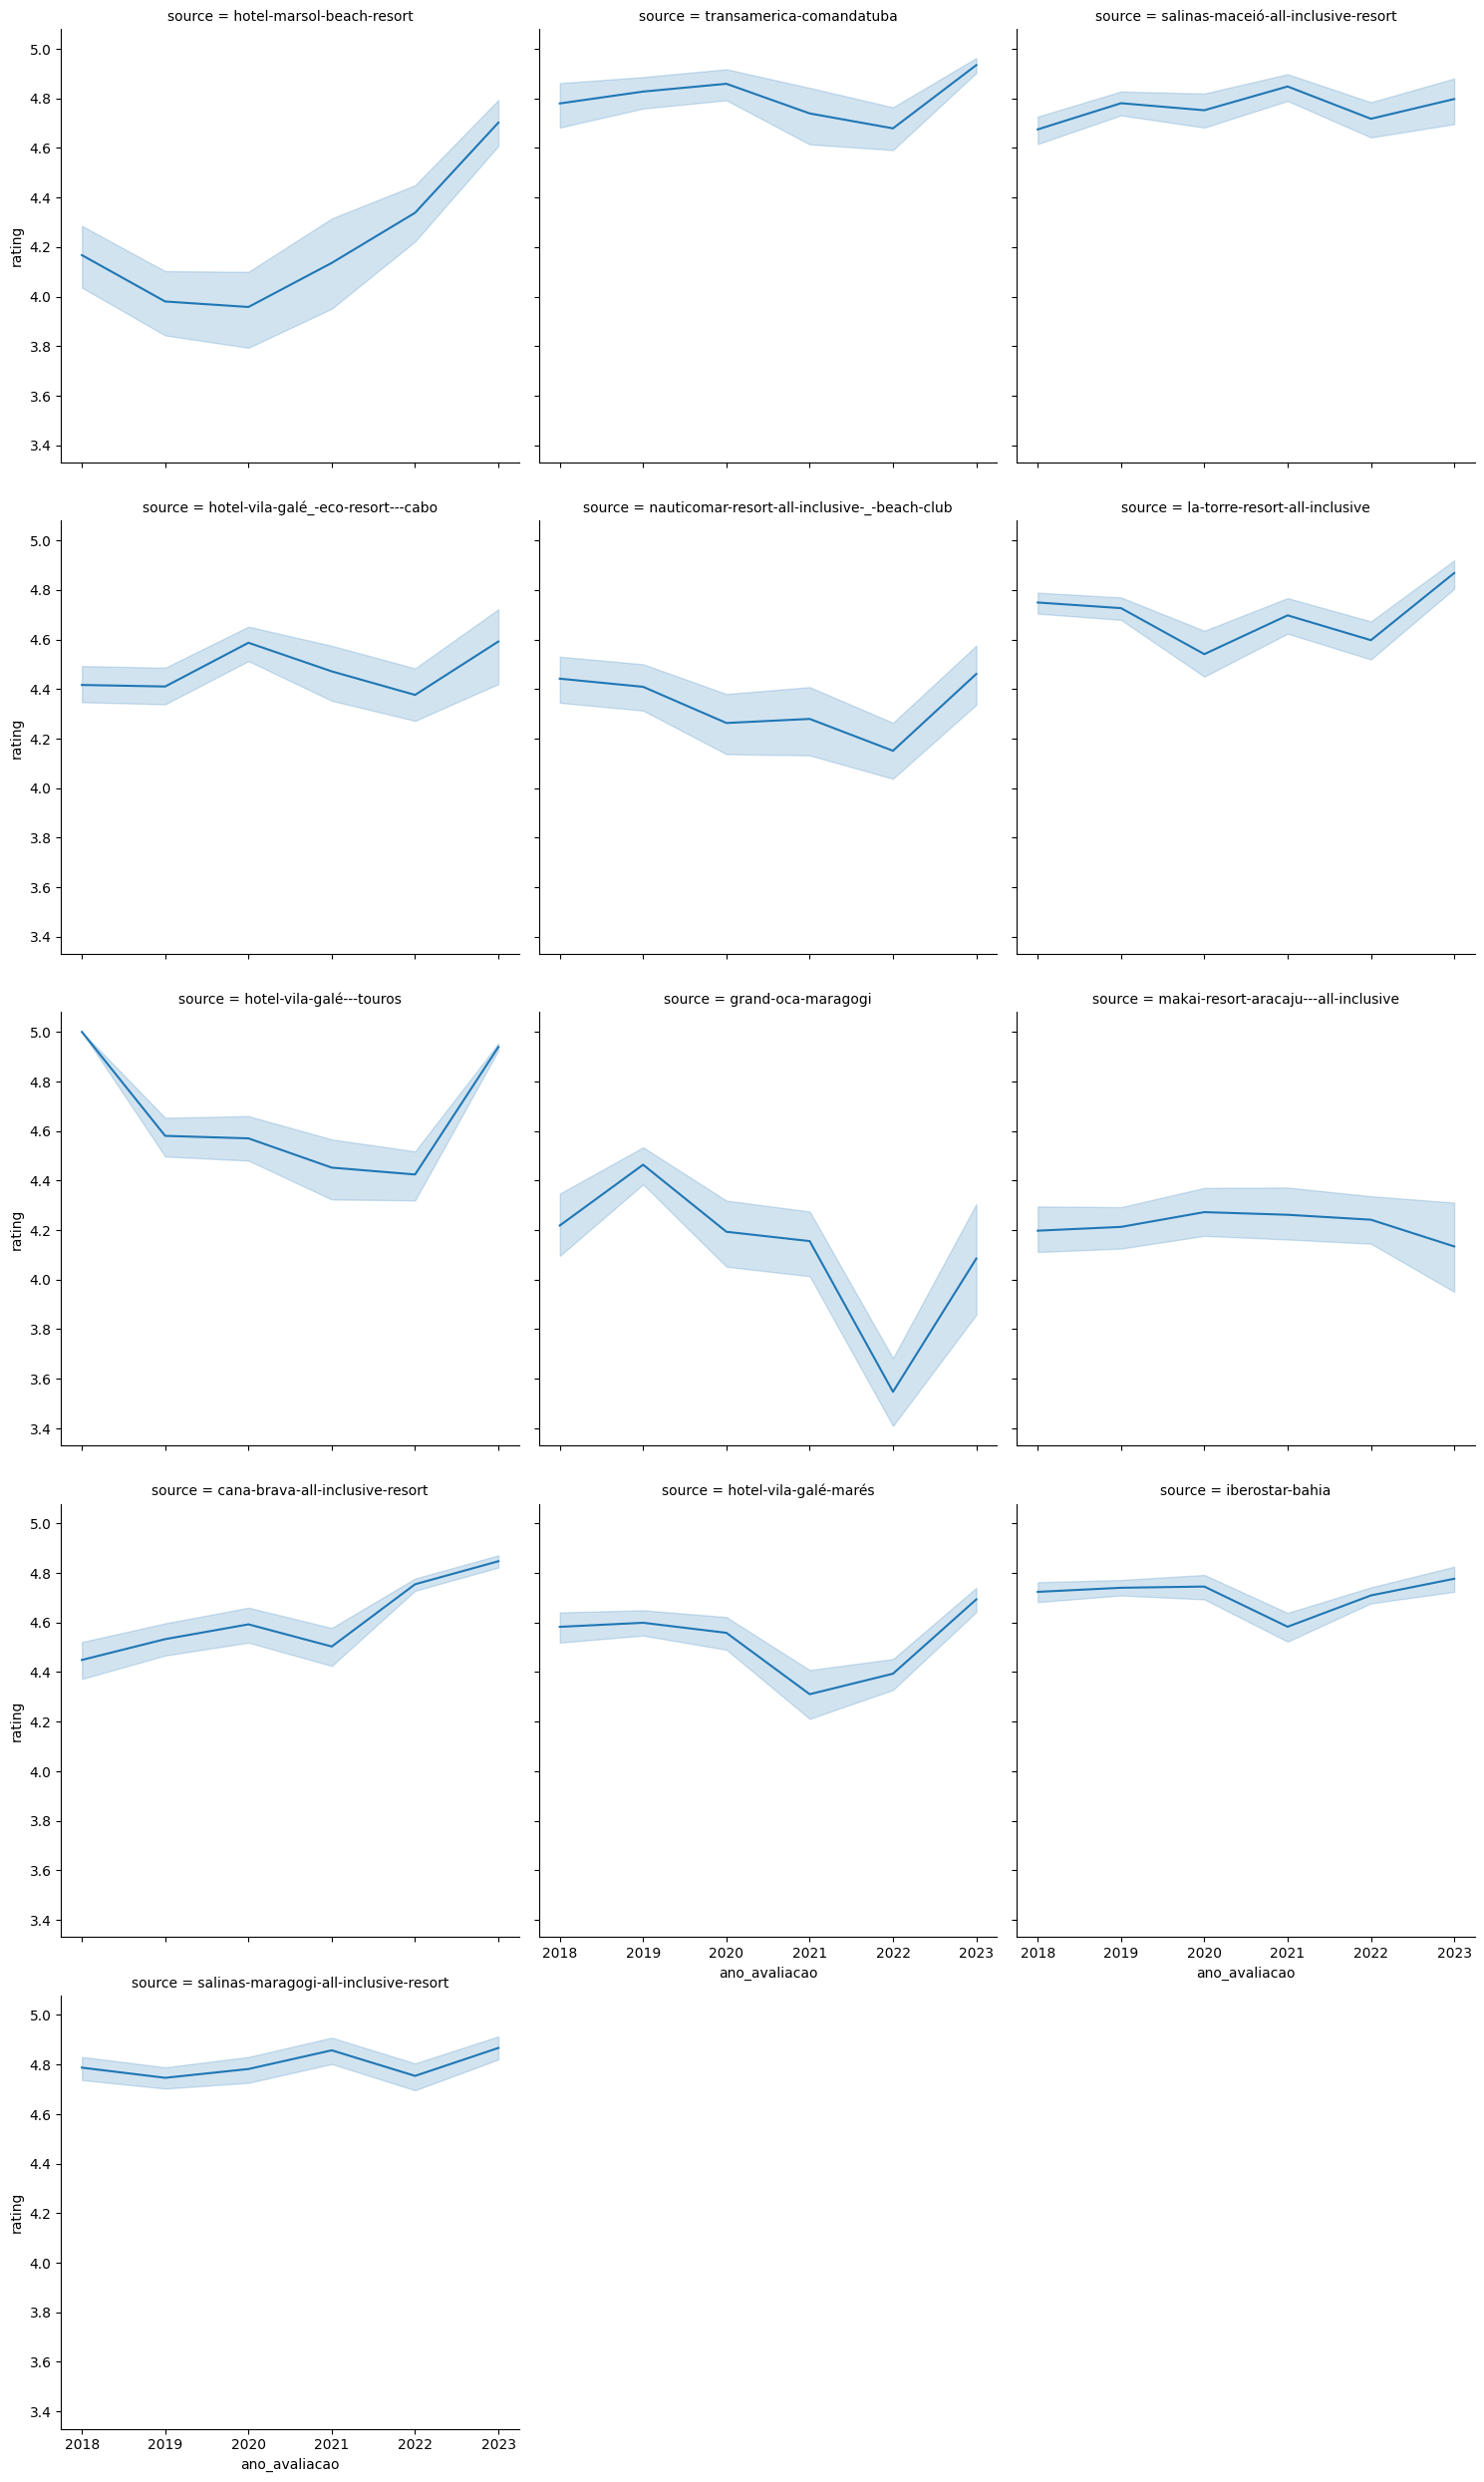

In [ ]:
sns.relplot(
    x='ano_avaliacao',
    y='rating',
    col='source',
    kind="line",
    col_wrap=3,
    data=analisar_df,
)
plt.show()

exemplo de algumas avaliações

In [ ]:
analisar_df[['rating', 'text', 'data_avaliacao', 'user_is_local_guide', 'user_reviews', 'source']].head()

,rating,text,data_avaliacao,user_is_local_guide,user_reviews,source
2,5.0,"Lugar fantástico, recomendo super.",2023-07-06,False,9,hotel-marsol-beach-resort
5,5.0,Tudo perfeito,2023-07-06,True,36,hotel-marsol-beach-resort
16,5.0,excelente!,2023-07-06,True,52,hotel-marsol-beach-resort
17,5.0,Belo lugar.,2023-07-06,True,41,hotel-marsol-beach-resort
19,5.0,Ótimo local,2023-07-06,False,7,hotel-marsol-beach-resort


### WordCloud

In [ ]:
from nltk.corpus import stopwords
from nltk import pos_tag
import string
import unicodedata

adicional = ["bem", "bom", "boa", "4", "pra", "vir", "super"]
# Adiciona novas stop words
new_stop_words = ["resort", "hotel", "all", "inclusive", "pois", "vila", "gale"]

def remove_stopword(tokens, remove_adicional):
  # Obtenha as stopwords em português
  stopwords_pt = stopwords.words('portuguese')

  stopwords_pt.extend(new_stop_words)

  if(remove_adicional):
    stopwords_pt.extend(adicional)

  # Remova as stopwords do texto
  tokens_sem_pontuacao = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
  tokens_sem_stopwords = [unicodedata.normalize('NFKD', token.lower()).encode('ASCII', 'ignore').decode('ASCII') for token in tokens_sem_pontuacao if token.lower() not in stopwords_pt and len(word) > 0]

  return [(word, pos) for word, pos in pos_tag(tokens_sem_stopwords) if len(word) > 0]

#### Geral todas as palavras

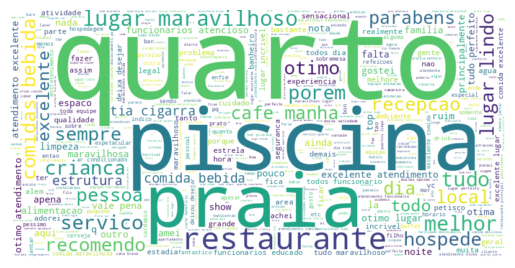

In [ ]:
# Concatenar todos os textos em uma única string
texto = ' '.join(analisar_df['text'].tolist())

# Tokenização das palavras
tokens = word_tokenize(texto, language='portuguese')

pos_tags = remove_stopword(tokens, True)
texto_sem_stopwords = ' '.join([word for word, pos in pos_tags])

# Criar um objeto WordCloud com as configurações desejadas
wc = WordCloud(background_color='white', max_words=1000, width=800, height=400)

# Gerar a nuvem de palavras
nuvem = wc.generate(texto_sem_stopwords)

# Exibir a nuvem de palavras
plt.imshow(nuvem, interpolation='bilinear')
plt.axis('off')
plt.show()


#### Substantivos

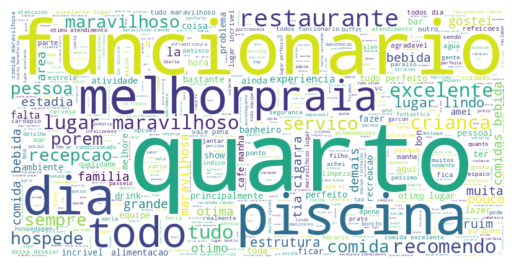

In [ ]:
nouns = [word for word, pos in pos_tags if pos.startswith('N')]

# Create a word cloud
noun = wc.generate(' '.join(nouns))

# Display the word cloud
plt.imshow(noun, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Adjetivos

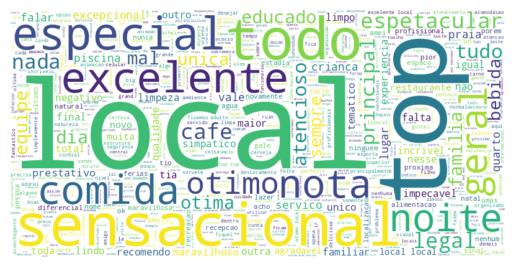

In [ ]:
adjs = [word for word, pos in pos_tags if pos.startswith('J')]

# Create a word cloud
adj = wc.generate(' '.join(adjs))

# Display the word cloud
plt.imshow(adj, interpolation='bilinear')
plt.axis('off')
plt.show()

### Distribuição de frequencia


#### Unigramas

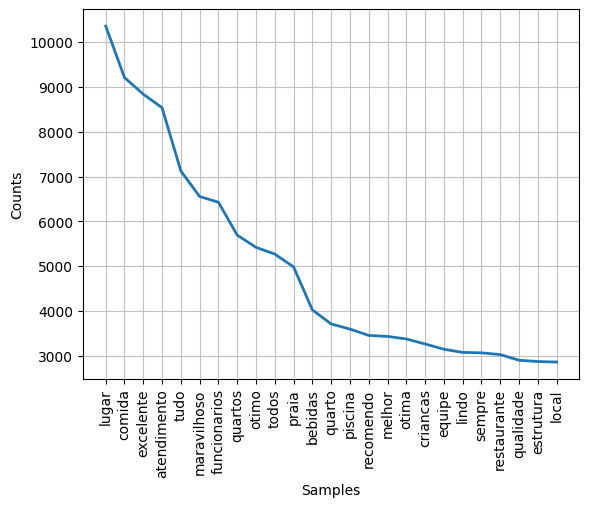

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
from nltk.probability import FreqDist
palavras = texto_sem_stopwords.split()

contagem = FreqDist(palavras)

contagem.plot(25)

#### Bigramas

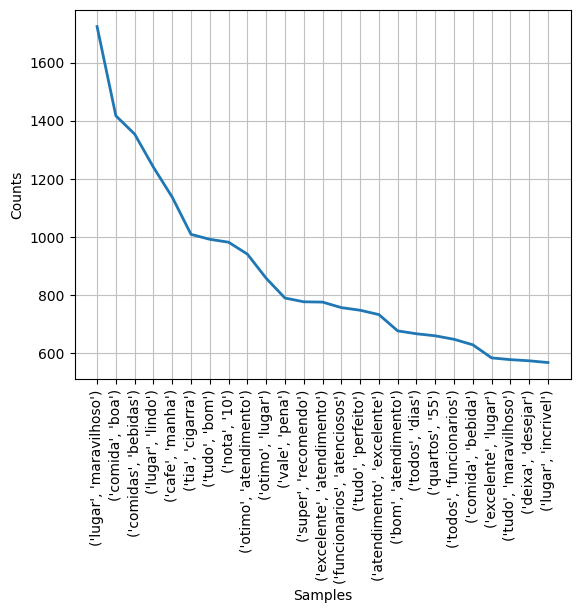

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
pos_tags = remove_stopword(tokens, False)
palavras = [word for word, pos in pos_tags]

#Create your bigrams
bgs = nltk.bigrams(palavras)

#compute frequency distribution for all the bigrams in the text
fdist = FreqDist(bgs)
fdist.plot(25)

#### Trigramas

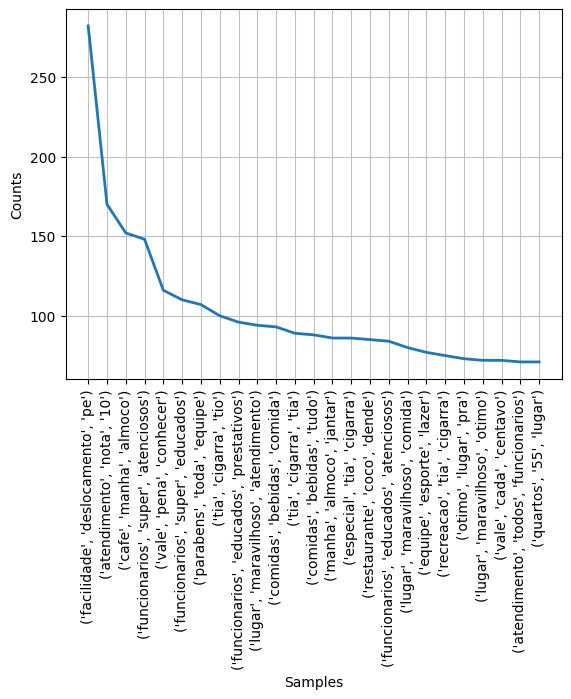

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
from nltk.collocations import TrigramCollocationFinder
from nltk.metrics import TrigramAssocMeasures

# Create a TrigramCollocationFinder
trigram = nltk.trigrams(palavras)

#compute frequency distribution for all the bigrams in the text
fdist = FreqDist(trigram)
fdist.plot(25)

## NOVO timechart

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud
import string
import matplotlib.pyplot as plt

def frequencia_ano(df, ano):
  texto = ' '.join(df[df['ano_avaliacao'] == ano]['text'].tolist())

  # Tokenização das palavras
  tokens = word_tokenize(texto, language='portuguese')
  pos_tags = remove_stopword(tokens, True)

  palavras = [word for word, pos in pos_tags]

  contagem = FreqDist(palavras)

  result = pd.DataFrame(contagem.items(), columns=['word', 'frequency'])
  result[ano] = result['frequency']
  return result[['word', ano]]

In [ ]:
from functools import reduce
anos = [2018, 2019, 2020, 2021, 2022, 2023]
datasets = reduce(lambda left, right: pd.merge(left, right, on='word', how='outer'), map(lambda ano: frequencia_ano(analisar_df, ano), anos)).fillna(0)

In [ ]:
datasets[datasets['word'] == 'lugar']

,word,2018,2019,2020,2021,2022,2023
26,lugar,1319.0,1974.0,1311.0,1182.0,2137.0,2438.0


In [ ]:
df_long = pd.melt(datasets, id_vars='word', var_name='year', value_name='value')

df_long.head(5)

,word,year,value
0,cafe,2018,177.0
1,manha,2018,163.0
2,nada,2018,156.0
3,agradavel,2018,213.0
4,faltam,2018,14.0


In [ ]:
faaa = analisar_df['text'].str.contains('ugar')
analisar_df[faaa].groupby('ano_avaliacao').count()

,retrieval_date,rating,relative_date,likes,user_is_local_guide,text,source,user_reviews,data_avaliacao,mes_avaliacao,mes_ano_avaliacao,com_texto,nao_vazio,traduzido,depois_2017,analisar
ano_avaliacao,,,,,,,,,,,,,,,,
2018,1272,1272,1272,1272,1272,1272,1272,1272,1272,1272,1272,1272,1272,1272,1272,1272
2019,1895,1895,1895,1895,1895,1895,1895,1895,1895,1895,1895,1895,1895,1895,1895,1895
2020,1273,1273,1273,1273,1273,1273,1273,1273,1273,1273,1273,1273,1273,1273,1273,1273
2021,1132,1132,1132,1132,1132,1132,1132,1132,1132,1132,1132,1132,1132,1132,1132,1132
2022,1993,1993,1993,1993,1993,1993,1993,1993,1993,1993,1993,1993,1993,1993,1993,1993
2023,2300,2300,2300,2300,2298,2300,2300,2300,2300,2300,2300,2300,2300,2300,2300,2300


In [ ]:
from datetime import date

keep = []
df_month = df_long.copy()
for i in anos:
    aux = df_month[df_month['year']==i].copy()
    order = aux['value'].rank(ascending=False)
    aux['rank'] = [int(i) for i in order]
    keep.append(aux)

df_month = pd.concat(keep)
df_month.sort_values(['year', 'word'], ascending=True,
                     inplace=True, ignore_index=True)

top_20 = df_month[df_month['rank'] < 11].copy()
top_20.head()

,word,year,value,rank
4033,atendimento,2018,930.0,4
7190,comida,2018,1012.0,3
12578,excelente,2018,1168.0,2
14028,funcionarios,2018,666.0,7
17841,lugar,2018,1319.0,1


In [ ]:
top_20.to_csv(f'/content/gdrive/MyDrive/tcc/exploratoria/tokens/{name}-top-20.csv', index=False)
df_month.to_csv(f'/content/gdrive/MyDrive/tcc/exploratoria/tokens/{name}-df-month.csv', index=False)

In [ ]:
#extract color palette, the palette can be changed
list_dist = list(set(top_20['word']))
pal = list(sns.color_palette(palette='Spectral',
                             n_colors=len(list_dist)).as_hex())
dict_color = dict(zip(list_dist, pal))

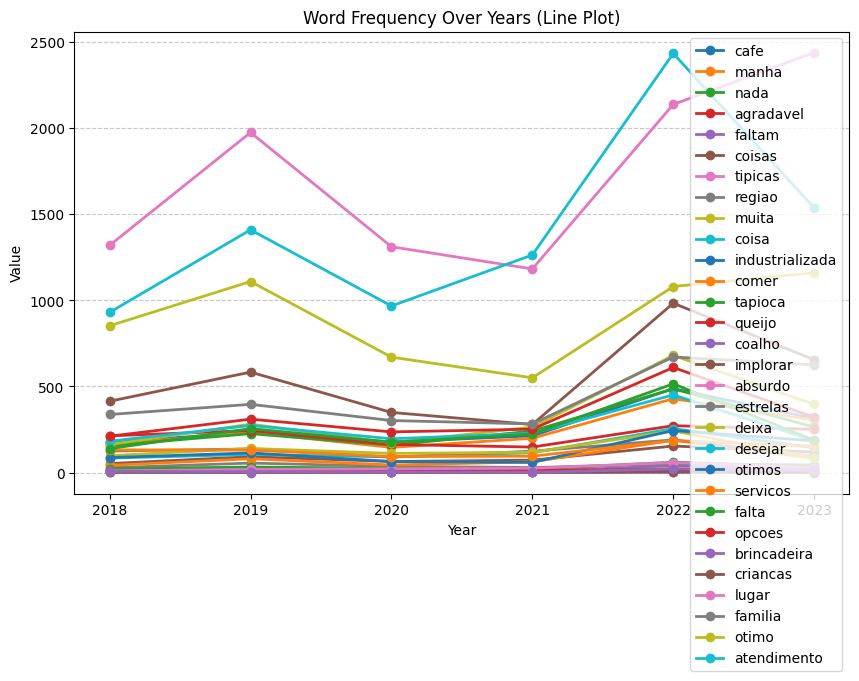

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Reshape the DataFrame to long format
df_long = datasets.head(30).melt(id_vars='word', var_name='year', value_name='value')

# Create the line plot
plt.figure(figsize=(10, 6))
for word in df_long['word'].unique():
    word_data = df_long[df_long['word'] == word]
    plt.plot(word_data['year'], word_data['value'], label=word, marker='o', linestyle='-', linewidth=2)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Word Frequency Over Years (Line Plot)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Display the plot
plt.show()

https://towardsdatascience.com/7-visualizations-with-python-to-express-changes-in-rank-over-time-71c1f11d7e4b

In [ ]:
ym = list(anos)
ym.sort()

top_20['posi'] = top_20['year'].apply(lambda x: ym.index(x))
top_20['value_str'] = top_20['value'].apply(lambda x: str(round(x, 2)))
top_20['value_text'] = top_20['value_str']

In [ ]:
import plotly.express as px
fig = px.scatter(top_20, x='posi', y='rank',
                 size= 'value',
                 color='word', text='value_text',
                 color_discrete_map= dict_color,
                 animation_frame='year',
                 animation_group='word',
                 range_x=[-2,len(ym)],
                 range_y=[0.5,6.5]
                )
fig.update_xaxes(title='', visible=False)
fig.update_yaxes(autorange='reversed', title='Rank',
                 visible=True, showticklabels=True)
fig.update_layout(xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=True))
fig.update_traces(textposition='middle left')
fig.show()

In [ ]:
import plotly.express as px
fig = px.line(top_20, x = 'year', y = 'rank',
              color = 'word',
              color_discrete_map= dict_color,
              markers=True,
              hover_name = 'value_text')
fig.update_traces(marker=dict(size=11)), "pra"
fig.update_yaxes(autorange='reversed', title='Rank',
                 visible=True, showticklabels=True)
fig.update_xaxes(title='', visible=True, showticklabels=True)
fig.update_layout(xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False) )
fig.show()

In [ ]:
datasets[datasets['word'] == 'lugar']

,word,2018,2019,2020,2021,2022,2023
26,lugar,1319.0,1974.0,1311.0,1182.0,2137.0,2438.0


In [ ]:
# Criar o gráfico de dispersão usando o Seaborn
plt.figure(figsize=(10, 6))  # Definir o tamanho da figura
scatter_plot = sns.scatterplot(data=datasets, x='year', y='word', size='frequency', sizes=(30, 300), legend=False)

# Adicionar rótulos de frequência aos pontos
for _, row in datasets.iterrows():
    scatter_plot.text(row['word'], row['year'], row['frequency'], ha='center', va='center', fontsize=9)

# Definir título e rótulos dos eixos
plt.title('Frequência das palavras por ano')
plt.xlabel('Palavra')
plt.ylabel('Ano')

# Girar os rótulos do eixo X para melhor legibilidade
plt.xticks(rotation=45, ha='right')

# Exibir o gráfico
plt.tight_layout()
plt.show()

ValueError: ignored

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Criar o gráfico de barras para visualizar a frequência dos n-grams ao longo do tempo
plt.figure(figsize=(12, 6))
sns.barplot(data=datasets, x='year', y='frequency', hue='word')
plt.title(f'Frequência por ano')
plt.xlabel('Ano')
plt.ylabel('Frequência')
plt.legend(title='N-gram')
plt.show()

ValueError: ignored

<Figure size 1200x600 with 0 Axes>

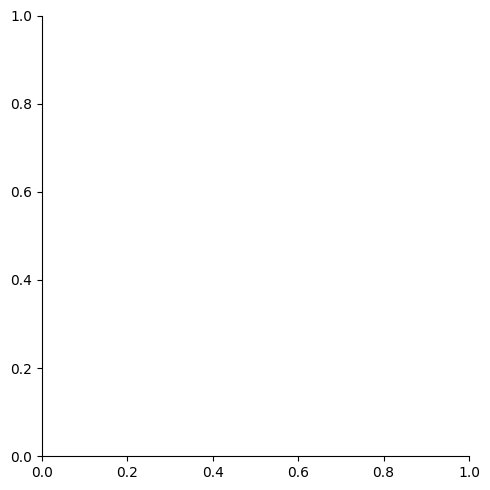

In [ ]:
sns.relplot(x='ano_avaliacao', y='rating', kind="line", data=analisar_df[analisar_df['source']  == source])

In [ ]:
palavras

['lugar',
 'fantastico',
 'recomendo',
 'super',
 'tudo',
 'perfeito',
 'excelente',
 'belo',
 'lugar',
 'otimo',
 'local',
 'excelente',
 'local',
 'otima',
 'vista',
 'hospitalidade',
 'pessoas',
 'boas',
 'otimno',
 'atendimento',
 'quartos',
 'bom',
 'recomendo',
 'otimo',
 'escolha',
 'excente',
 'atendimento',
 'comida',
 'qualidade',
 'otimo',
 'servico',
 'quarto',
 'maravilhoso',
 'otima',
 'estadia',
 'recepcao',
 'incrivel',
 'recomendo',
 'lugar',
 'maravilhoso',
 'otimo',
 'atendimento',
 'comidas',
 'deliciosas',
 'ambiente',
 'super',
 'agradavel',
 'otima',
 'vista',
 'vale',
 'pena',
 'local',
 'maravilhoso',
 'preciso',
 'destacar',
 'ambiente',
 'super',
 'recomendo',
 'quartos',
 'aconchegante',
 'lugar',
 'lindo',
 'proximo',
 'praia',
 'perfeito',
 'maravilhoso',
 'vista',
 'lindissima',
 'praia',
 'cafe',
 'manha',
 'excelencia',
 'otimas',
 'programacoes',
 'adoramos',
 'aproveitar',
 'quadra',
 'piscinas',
 'quadra',
 'piscina',
 'praca',
 'lado',
 'praia',
 'e

In [ ]:
pos_tags

[('lugar', 'NN'),
 ('fantastico', 'NN'),
 ('recomendo', 'VBZ'),
 ('super', 'JJ'),
 ('tudo', 'NN'),
 ('perfeito', 'NN'),
 ('excelente', 'NN'),
 ('belo', 'NN'),
 ('lugar', 'NN'),
 ('otimo', 'VBZ'),
 ('local', 'JJ'),
 ('excelente', 'FW'),
 ('local', 'JJ'),
 ('otima', 'NN'),
 ('vista', 'NN'),
 ('hospitalidade', 'VBD'),
 ('pessoas', 'JJ'),
 ('boas', 'NN'),
 ('otimno', 'NN'),
 ('atendimento', 'IN'),
 ('quartos', 'NNS'),
 ('bom', 'VBP'),
 ('recomendo', 'NN'),
 ('otimo', 'MD'),
 ('escolha', 'VB'),
 ('excente', 'FW'),
 ('atendimento', 'IN'),
 ('comida', 'NN'),
 ('qualidade', 'NN'),
 ('otimo', 'NN'),
 ('servico', 'NN'),
 ('quarto', 'NN'),
 ('maravilhoso', 'NN'),
 ('otima', 'IN'),
 ('estadia', 'JJ'),
 ('recepcao', 'NN'),
 ('incrivel', 'NN'),
 ('recomendo', 'NN'),
 ('lugar', 'NN'),
 ('maravilhoso', 'NN'),
 ('otimo', 'NN'),
 ('atendimento', 'NN'),
 ('comidas', 'NN'),
 ('deliciosas', 'NN'),
 ('ambiente', 'VBZ'),
 ('super', 'JJR'),
 ('agradavel', 'NN'),
 ('otima', 'NN'),
 ('vista', 'NN'),
 ('vale', '

In [ ]:
nltk.help.upenn_tagset('.*')

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or